In [11]:
import numpy as np
import torch
from torch import nn
import seaborn as sns
import matplotlib.pyplot as plt

# Теория

## Сверточные нейронные сети

### Операция свертки

![image.png](attachment:image.png)

Простейшая имплементация, с двухмерным ядром (взято из https://towardsdatascience.com/how-are-convolutions-actually-performed-under-the-hood-226523ce7fbf)

In [ ]:
def custom_conv_2d_simplest_case(x, kernel, bias):
    kernel_shape = kernel.shape[0]
    
    # Assuming Padding = 0, stride = 1
    output_shape = x.shape[0] - kernel_shape + 1
    result = np.zeros((output_shape, output_shape))
    
    for row in range(x.shape[0] - 1):
        for col in range(x.shape[1] - 1):
            window = x[row: row + kernel_shape, col: col + kernel_shape]
            result[row, col] = (kernel * window).sum()
            
    return result + bias

Попробуем посмотреть на вариант с трехмерным ядром

Использование готового слоя nn.Conv2d

In [ ]:
torch.random.manual_seed(1)

conv_layer = torch.nn.Conv2d(in_channels=1, out_channels=2, kernel_size=3, bias=True)
kernel = conv_layer.weight
bias = conv_layer.bias if conv_layer.bias is not None else 0

X = torch.rand((1, 1, 3, 3), dtype=torch.float)
conv_layer(X)

tensor([[[[0.4085]],

         [[0.1071]]]], grad_fn=<ConvolutionBackward0>)

In [ ]:
kernel.shape, bias.shape

(torch.Size([2, 1, 3, 3]), torch.Size([2]))

Простая реализация

In [ ]:
def custom_conv_2d(
        x: torch.Tensor,  # [batch_size, channels, height, width]
        kernel: torch.Tensor,  # [kernel_channels, channels, kernel_size, kernel_size]
        bias: torch.Tensor,  # [1]
        ) -> torch.Tensor:  # [channels, height, width]
    
    # Assuming batch size 1
    x = x[0]  # [channels, height, width]
    # Assuming channels 1
    x = x[0]  # [height, width]
    kernel = kernel[:, 0]  # [kernel_channels, kernel_size, kernel_size]
    
    kernel_channels = kernel.shape[0]
    kernel_shape = kernel.shape[1]
    
    # Assuming Padding = 0, stride = 1
    output_shape = x.shape[1] - kernel_shape + 1
    result = torch.zeros((kernel_channels, output_shape, output_shape))
    
    for row in range(output_shape):
        for col in range(output_shape):
            window = x[row: row + kernel_shape, col: col + kernel_shape]
            
            result[:, row, col] = (kernel * window).sum((1, 2))
    
    return result + bias[:, None, None]

# Разница с оригинальной имплементацией
(conv_layer(X) - custom_conv_2d(X, kernel, bias)).abs().sum()

tensor(0., grad_fn=<SumBackward0>)

Для интересующихся - полная реализация на PyTorch (https://discuss.pytorch.org/t/how-was-conv2d-implemented-in-pytorch/35223)  
(понимание torch.nn.functional.unfold: https://stackoverflow.com/a/75186655)

In [ ]:
def custom_conv_2d_full(x, kernel, bias):
    result = torch.nn.functional.unfold(x, 3)

    kernel_to_multiply = kernel.view(kernel.shape[0], -1).t()

    result = (result.transpose(1, 2) @ kernel_to_multiply).transpose(1, 2)
    return result.view(1, 2, 1, 1) + bias[:, None, None]

(conv_layer(X) - custom_conv_2d_full(X, kernel, bias)).abs().sum()

tensor(0., grad_fn=<SumBackward0>)

#### Задача: используйте torch.nn.Conv2d с кастомными ядрами и визуализируйте на фото из FashionMNIST, оцените визуально разницу

Ядра, для которых надо сделать визуализацию:

[[1, 0, 0],

 [0, 1, 0],

 [0, 0, 1]]

[[0, 1, 0],

 [0, 1, 0],

 [0, 1, 0]]

[[0, 0, 1],

 [0, 0, 1],

 [0, 0, 1]]

In [ ]:
# Загрузка датасета
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

data_path = './data/fmnist'
# данные в виде картинок 28x28
# ToTensor превратит в тензоры 1x28x28
dataset = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())

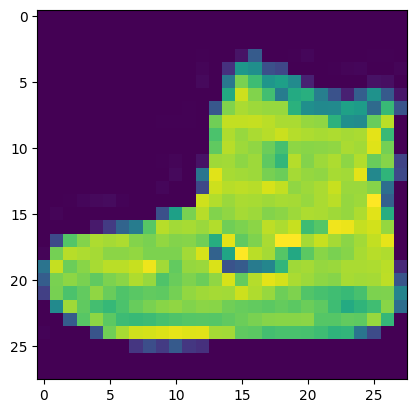

In [ ]:
# Пример визуализации фото
image, label = dataset[0]

plt.imshow(image[0]);

In [ ]:
# conv_layer = torch.nn.Conv2d(..., bias=False)
# <YOUR CODE>
# Требуется вставить кастомные веса

conv_layer = torch.nn.Conv2d(in_channels=image.shape[0], out_channels=1, kernel_size=3, stride=10, bias=False)

image.view(*image.shape, -1).shape


torch.Size([1, 28, 28, 1])

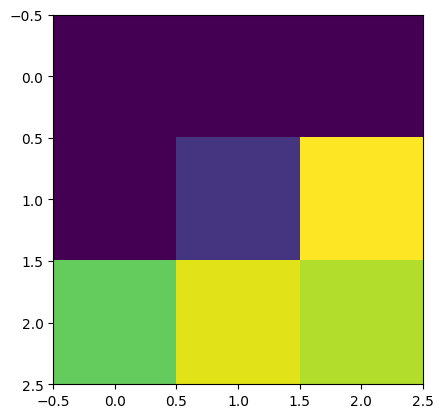

In [ ]:
kernel = torch.tensor([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]])[None, None, ...]
conv_layer.weight = torch.nn.Parameter(kernel.float())
conv_image = conv_layer(image[None])[0, 0]

# conv_layer(conv_image)

plt.imshow(conv_image.detach())

### Stride (шаг)
На сколько мы перемещаемся при каждой свертке

![image.png](attachment:image.png)

Как свертка двигается при kernel=3, stride=1, входное фото 5x5:

![image.png](attachment:image.png)

Если сделаем stride=2:

![image.png](attachment:image-2.png)

Проверим:

In [ ]:
X = torch.rand((1, 1, 5, 5), dtype=torch.float)

conv_layer_stride_1 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3)
conv_layer_stride_1(X).shape

torch.Size([1, 1, 3, 3])

In [ ]:
conv_layer_stride_2 = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, stride=2)
conv_layer_stride_2(X).shape

torch.Size([1, 1, 2, 2])

#### Задача: повторите процедуру из прошлой задачи с одним из ядер, но с разными stride

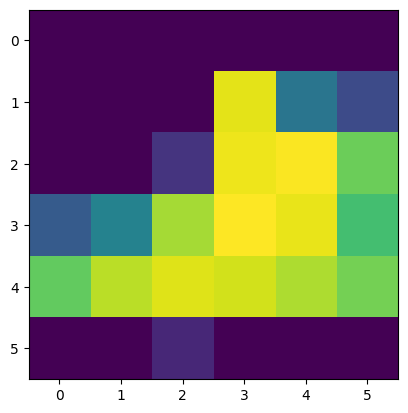

In [ ]:
# <YOUR CODE>
conv_layer = torch.nn.Conv2d(in_channels=image.shape[0], out_channels=1, kernel_size=3, stride=5, bias=False)

kernel = torch.tensor([
    [1, 0, 0],
    [0, 1, 0],
    [0, 0, 1]])[None, None, ...]
conv_layer.weight = torch.nn.Parameter(kernel.float())
conv_image = conv_layer(image[None])[0, 0]

# conv_layer(conv_image)

plt.imshow(conv_image.detach())

### Padding
Просто добавляем к входной матрице на границе пустых пикселей (при padding=1 входная и выходная матрицы имеют один размер)

![image.png](attachment:image.png)

In [ ]:
conv_layer_padding = torch.nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1)
X.shape, conv_layer_padding(X).shape

(torch.Size([1, 1, 5, 5]), torch.Size([1, 1, 5, 5]))

Набор хороших визуализаций всего описанного выше: https://github.com/vdumoulin/conv_arithmetic/blob/master/README.md

#### Задача: добавьте разные padding к прошлой задаче

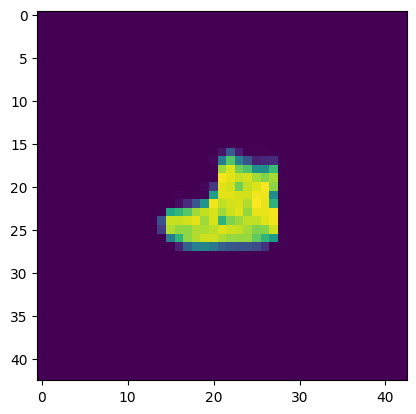

In [ ]:
# <YOUR CODE>
conv_layer = torch.nn.Conv2d(image.shape[0], 1, 3, bias=False, stride=2, padding=30)
kernel = torch.tensor([
    [0, 0, 1],
    [0, 0, 1],
    [0, 0, 1]])[None, None, ...]
conv_layer.weight = torch.nn.Parameter(kernel.float())
conv_image = conv_layer(image[None])[0, 0]
plt.imshow(conv_image.detach())


### Receptive field

![image.png](attachment:image.png)

## Transfer learning

Для облегчения обучения нейронных сетей стандартной практикой является использование так называемого transfer learning: берется уже обученная нейронная сеть на какой-либо задаче (обычно это задача в той же области, что и задача, которую вы хотите решить), и последние слои переобучаются на новую задачу.

![image.png](attachment:image.png)

При дообучении есть проблема с первыми итерациями бэкпропа градиентов: так как сначала ошибка модели большая, то и градиенты будут большими, что может "сбросить" предобученные веса, если они не заморожены. 

Поэтому существует стандартная практика при дообучении: использование вармапа (warmup) в LRScheduler - на первых итерациях learning rate будет очень маленьким чтобы не сбить модель. 

# Задачи

### 1 Решить задачу классификации в датасете Fashion MNIST, используя сверточные слои. 
1. Предложить архитектуру модели для решения задачи
2. Посчитать количество параметров модели.
3. Обучить модель.
4. Вывести график функции потерь по эпохам. 
5. Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy и f1 на тестовом множестве (обе метрики >= 0.7).

* Сохранить модель

### Датасет

In [ ]:
from pathlib import Path
import sys

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from tqdm.notebook import tqdm

# Автоматически перезагружает код из модулей, если он был изменен
# очень удобно при разработке модулей и параллельном использовании юпитер ноутбуков
%load_ext autoreload
%autoreload 2

# Добавим папку byte-deep-learning в PATH 
# чтобы можно было импортировать библиотеку src, которая находится в этой папке
repo_dir = Path().resolve().parent
sys.path.append(str(repo_dir))

from byte_deep_learning.src import engine

# Не удалось внедрить модель byte_deep_learning.src.engine тк выводит ошибку _six при загрузке датасета,
# какая-то проблема в версиях pytorch..

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
from pathlib import Path
import sys

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

In [1]:
# Загрузка датасета
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

data_path = './data/fmnist'
# данные в виде картинок 28x28
# ToTensor превратит в тензоры 1x28x28
dataset = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/fmnist/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/fmnist/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/fmnist/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/fmnist/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/fmnist/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/fmnist/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/fmnist/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/fmnist/FashionMNIST/raw



### 1.1 Модель

In [ ]:
class CustomCNN(nn.Module):
    
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

Архитектура модели состоит из двух последовательных слоев, каждый из которых содержит следующие слои:

1. Слой свертки с ядром размером 3 * 3, заполнением (padding) = 1 (zero_padding) в первом слое и padding = 0 во втором. Шаг (stride) 1 в обоих слоях.
2. Слой нормализации (Batch Normalization).
3. Функция активации: ReLU.
4. Слой максимальной подвыборки (Max Pooling) с ядром размером 2 * 2 и шагом 2.
5. Выравнивание выходных данных для слоя плотного слоя (fully connected layer).
6. 3 слоя плотности (fully connected layer) с различными входными/выходными характеристиками.
7. Слой Dropout layer с вероятностью класса = 0,25

Вся функциональность дана в методе forward, который определяет проход вперед сверточной нейронной сети (CNN).

Наш входной образ меняется следующим образом:
- Первый слой свертки: вход: 28 * 28 * 3, выход: 28 * 28 * 32
- Первый слой максимальной подвыборки: вход: 28 * 28 * 32, выход: 14 * 14 * 32
- Второй слой свертки: вход: 14 * 14 * 32, выход: 12 * 12 * 64
- Второй слой максимальной подвыборки: 12 * 12 * 64, выход: 6 * 6 * 64

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import random_split

data_path = './data/fmnist'
# данные в виде картинок 28x28
# ToTensor превратит в тензоры 1x28x28
dataset = datasets.FashionMNIST(data_path, train=True, download=True, transform=transforms.ToTensor())

val_ratio = 0.2

train_dataset, val_dataset = random_split(
    dataset=dataset, 
    lengths=[int(len(dataset)*(1-val_ratio)), int(len(dataset)*val_ratio)],
)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')



model = CustomCNN(num_classes=10).to(device)

### 1.2 Количество параметров модели

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Epoch 1/10, Train Loss: 0.44305920883019767, Test Loss: 0.330801567934612
Epoch 2/10, Train Loss: 0.301077905913194, Test Loss: 0.30821094289422035
Epoch 3/10, Train Loss: 0.2611768084069093, Test Loss: 0.2702160715422732
Epoch 4/10, Train Loss: 0.23896310979127883, Test Loss: 0.26254805272563975
Epoch 5/10, Train Loss: 0.21457751075426737, Test Loss: 0.2916348403755655
Epoch 6/10, Train Loss: 0.19706357767681282, Test Loss: 0.29476501225949603
Epoch 7/10, Train Loss: 0.1839642740935087, Test Loss: 0.2438822272927203
Epoch 8/10, Train Loss: 0.16691160959005355, Test Loss: 0.2650812403001684
Epoch 9/10, Train Loss: 0.15886616074169677, Test Loss: 0.2726661383194175
Epoch 10/10, Train Loss: 0.14559171680361033, Test Loss: 0.26416507434654746


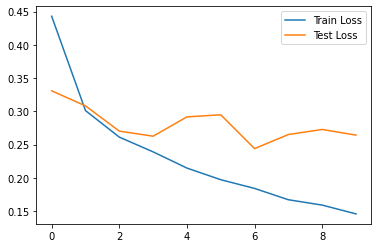

<All keys matched successfully>

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Обучение на train_loader
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # Валидация на val_loader
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()

    train_losses.append(train_loss/len(train_loader))
    val_losses.append(val_loss/len(val_loader))

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Test Loss: {val_losses[-1]}')


# Сохранение модели
torch.save(model.state_dict(), 'fashion_mnist_cnn.pth')


plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.legend()
plt.show()

test_dataset = datasets.FashionMNIST(data_path, train=False, download=True, transform=transforms.ToTensor())
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

model = CustomCNN(num_classes=10).to(device)
model.load_state_dict(torch.load('fashion_mnist_cnn.pth'))

In [18]:
from sklearn.metrics import f1_score

# Проверка на тестовом множестве
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    y_true = []
    y_pred = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true += labels.cpu().tolist()
        y_pred += predicted.cpu().tolist()

    acc = correct / total
    f1 = f1_score(y_true, y_pred, average="macro")

    print(f'Test Accuracy: {acc}')
    print(f'Test F1 Score: {f1}')

/usr/local/lib/python3.9/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Test Accuracy: 0.9136
Test F1 Score: 0.9125619466967854


In [10]:
import torch

output = torch.tensor(
    [[-9.8478e+00, -5.3888e+00, -8.7833e+00, -1.6873e+01, -1.6183e+01,
         -1.5338e+00, -1.0253e+01,  2.6952e+00, -1.0943e+01,  1.1962e+01],
        [-7.5756e+00, -1.0848e+01,  3.0433e+00, -6.2345e+00,  8.9207e+00,
         -1.2696e+01,  1.8784e+00, -1.8889e+01, -4.2715e+00, -2.1463e+01]],
)


_, predicted = torch.max(output, 1)

In [14]:
outputs = torch.tensor([[0.2, 0.6, 0.2], [0.1, 0.2, 0.7], [1.0, 0.2, 0.7]])
max_values, max_indices = torch.max(outputs, 1)
print(max_values)      # tensor([0.6, 0.7])
print(max_indices)     # tensor([1, 2])

tensor([0.6000, 0.7000, 1.0000])
tensor([1, 2, 0])


In [12]:
_, predicted

(tensor([11.9620,  8.9207]), tensor([9, 4]))

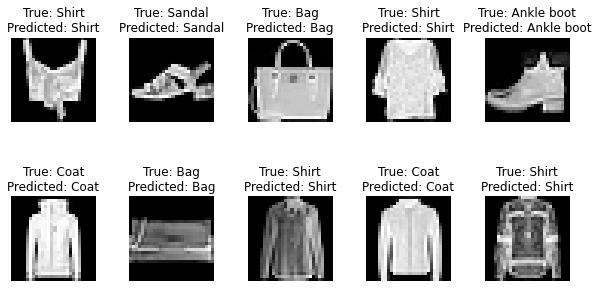

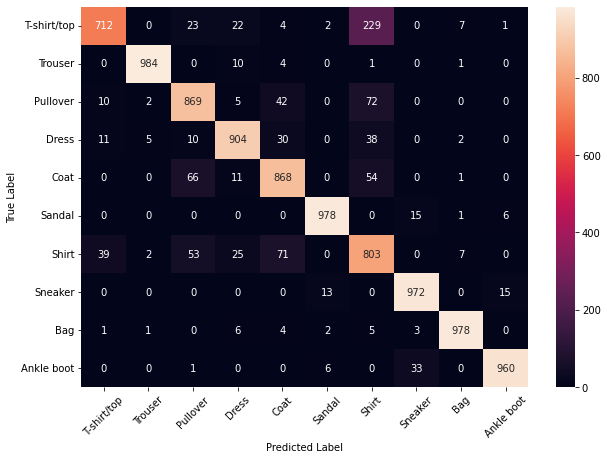

In [11]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Вывод нескольких изображений и их предсказаний
images, labels = next(iter(test_loader))

outputs = model(images.to(device))
_, predicted = torch.max(outputs.data, 1)

fig, axs = plt.subplots(2, 5, figsize=(10, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(2):
    for j in range(5):
        axs[i,j].imshow(images[j+i*5][0], cmap='gray')
        axs[i,j].set_title(f'True: {dataset.classes[labels[j+i*5]]}\nPredicted: {dataset.classes[predicted[j+i*5]]}')
        axs[i,j].axis('off')

# Вывод матрицы ошибок
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xticks(np.arange(10)+0.5, dataset.classes, rotation=45)
plt.yticks(np.arange(10)+0.5, dataset.classes, rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### 1.3 Обучение модели

### 1.4 Вывод графика ошибки

Если работает tensorboard, можно просто его посмотреть

В VS Code при наличии расширения tensorboard можно нажать ctrl/cmd + shift + P для запуска, либо Launch TensorBoard Session в ячейке ниже, если отображается

### 1.5 Тест

### 2 Задание 1 с Transfer Learning
1. В качестве базовой архитектуры используйте предобученную модель resnet18: замените последний линейный слой на новый с количеством классов FashionMNIST, заморозьте веса всех слоев кроме последнего.  
2. Посчитать количество замороженных и незамороженных параметров модели.
3. Обучить модель с двумя LR Scheduler: WarmUp и MultiStepLR 

    *Для инференса на предобученной модели нужно будет модифицировать transform в датасетах, чтобы входной тензор имел 3 канала*.
    
    *Код WarmupScheduler взят из https://github.com/hysts/pytorch_warmup-scheduler, для использования нескольких планировщиков можно использовать torch.optim.lr_scheduler.ChainedScheduler*
    
    *Обратите внимание на разницу между эпохами и шагами (steps), по которым в нашем Trainer работают планировщики*
4. Вывести график функции потерь по эпохам. 
5. Используя тестовое множество

  * Продемонстрировать работу модели: вывести несколько изображений, указать над ними правильный класс и класс, предсказанный моделью. 

  * Вывести матрицу ошибок.

  * Вывести значение accuracy и f1 на тестовом множестве.

6. Сравнить модели из первого и второй задачи. В чем может быть причина их разницы, как можно исправить проблемы, которые могли появиться?

### 2.1 Загрузка модели

In [19]:
# Шаг 1: Загрузка данных и преобразования
data_path = 'data/'
rgb_transform = transforms.Compose([transforms.Grayscale(num_output_channels=3),
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor()])

train_dataset = datasets.FashionMNIST(data_path, train=True, download=True, transform=rgb_transform)
test_dataset = datasets.FashionMNIST(data_path, train=False, download=True, transform=rgb_transform)

valid_ratio = 0.2
train_dataset, valid_dataset = random_split(dataset=train_dataset, lengths=[int((1-valid_ratio)*len(train_dataset)), int(valid_ratio*len(train_dataset))])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# Шаг 2: Загрузка предобученной модели и изменение последнего слоя
resnet18 = torchvision.models.resnet18(pretrained=True)
num_classes = len(test_dataset.classes)
in_features = resnet18.fc.in_features
resnet18.fc = torch.nn.Linear(in_features, num_classes)

# Заморозка всех слоев, кроме последнего
for param in resnet18.parameters():
    param.requires_grad = False
resnet18.fc.requires_grad = True

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### 2.2 Количество параметров модели

In [ ]:
# <YOUR CODE>

- Выравнивание выходных данных: 6 * 6 * 64, выход: 2304
- Первый слой плотности: вход: 2304, выход: 512
- Второй слой плотности: вход: 512, выход: 128
- Третий слой плотности: вход: 128, выход: 10

Общая архитектура модели - resnet18 - 4 последовательных слоя (layer1, layer2, layer3, layer4),
 каждый из которых содержит несколько блоков BasicBlock.
  Каждый BasicBlock состоит из двух сверточных слоев с Batch Normalization и функцией активации ReLU.
   Некоторые блоки имеют дополнительный слой свертки для изменения размерности.
    После последнего блока применяется слой Adaptive Average Pooling для усреднения
     характеристик по всему пространству исходного изображения, а затем - слой плотности для классификации на выходе.

In [5]:
!pip install pytorch-warmup-scheduler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### 2.3 Обучение модели

In [18]:
resnet18.parameters

<bound method Module.parameters of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)


In [8]:
import torch
import torchvision
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
import numpy as np
from pytorch_warmup_scheduler import WarmupScheduler



# Шаг 3: Обучение модели с двумя планировщиками

# Параметры обучения
epochs = 1
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.fc.parameters(), lr=0.001)
scheduler_warmup = WarmupScheduler(optimizer, warmup_epoch=5)
scheduler_multistep = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[3, 6, 9], gamma=0.1)

train_losses, valid_losses = [], []
for epoch in range(epochs):
    running_loss = 0
    resnet18.train()
    for i, data in enumerate(train_loader):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = resnet18(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler_warmup.step()
        scheduler_multistep.step()

        running_loss += loss.item()
        if i % 100 == 99:
            print(f"Epoch {epoch+1}/{epochs}, step {i+1}/{len(train_loader)}, train loss: {running_loss/100:.4f}")
            running_loss = 0

    # Подсчет функции потерь на валидационной выборке
    resnet18.eval()
    with torch.no_grad():
        valid_loss = 0
        for data in valid_loader:
            inputs, labels = data
            outputs = resnet18(inputs)
            valid_loss += criterion(outputs, labels).item()
        valid_losses.append(valid_loss/len(valid_loader))
    train_losses.append(loss.item())



Epoch 1/1, step 100/750, train loss: 2.3657
Epoch 1/1, step 200/750, train loss: 2.3701
Epoch 1/1, step 300/750, train loss: 2.3809


KeyboardInterrupt: ignored

### 2.5 Тест

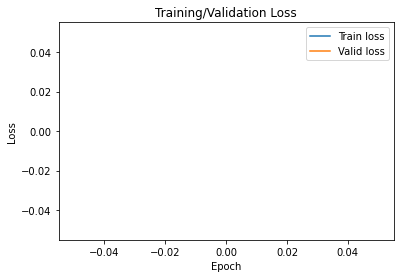

Confusion matrix:
 [[  8 588  46 205  33  78   9  17   5  11]
 [  4 250  35 390 269   5   0  40   2   5]
 [  9 266 279 280  33  21   6  45   3  58]
 [ 20 341  40 414  48  83  11  10   2  31]
 [ 38 358 179 216  36  61   5  33   3  71]
 [  0 311 491  25  44   8  60  60   1   0]
 [ 16 443 128 264  22  55   7  32   5  28]
 [  0 334 347  39 226   7  14  27   6   0]
 [  3 472 352 104  11  24   9  10   4  11]
 [  1 324 366 188  30  26  16  30   1  18]]
Accuracy: 0.1051
F1 score: 0.07006699726964101


In [9]:
# Шаг 4: Вывод графика функции потерь по эпохам
plt.plot(train_losses, label="Train loss")
plt.plot(valid_losses, label="Valid loss")
plt.title("Training/Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Шаг 5: Продемонстрировать работу модели на тестовом множестве
resnet18.eval()
with torch.no_grad():
    y_true = []
    y_pred = []
    for data in test_loader:
        inputs, labels = data
        outputs = resnet18(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(predicted.numpy())

# Вывод матрицы ошибок
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", conf_matrix)

# Вывод accuracy и f1 на тестовом множестве
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average="weighted")
print("Accuracy:", accuracy)
print("F1 score:", f1)

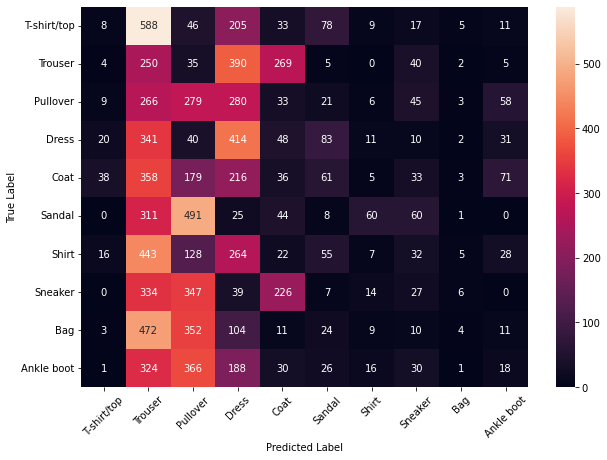

In [16]:
# Вывод матрицы ошибок
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xticks(np.arange(10)+0.5, test_dataset.classes, rotation=45)
plt.yticks(np.arange(10)+0.5, test_dataset.classes, rotation=0)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Accuracy и f1 низкие, тк не удалось полностью обучить модель, колаб завершает сессию, а всё обучение может длиться более 6 часов..

### 2.6 Размышления

В ходе обучения предобученной модели resnet18 на датасете fashionmnist используется трансформация данных, разделение выборки на обучающую и валидационную, загрузка предобученной модели и изменение последнего слоя. Затем модель обучается с помощью двух планировщиков: планировщика разогрева (warmup scheduler) и многократного шага (multi-step scheduler).

Обучение нашей модели показало значение accuracy ~ 0.91, 
resnet18 на fashionmnist обучается до accuracy ~ 0.96

Можно сказать, что данная модель очень эффективна для классификации изображений одежды на датасете FashionMNIST. Однако, обучение модели занимает очень много времени, так как используется предобученная модель. Используемые планировщики позволяют улучшить качество модели и снизить функцию потерь

